In [1]:
# Imports
import joblib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Carregando os dados
dsa_dados = pd.read_csv('CO2.csv')

In [3]:
# Shape
dsa_dados.shape

(1955, 5)

In [4]:
# Amostra dos dados
dsa_dados.sample(10)

,Time,AE,GDP,RE,CO2
1015,2014,88.653770,2206.054397,53.630000,1.056325
1059,2014,100.000000,8499.307148,1.200000,3.149295
602,2012,95.384079,8992.171694,1.638212,5.730132
1755,2017,98.853836,3978.676452,8.740000,0.879894
584,2012,78.306747,14721.869240,2.720000,9.168356
1842,2018,100.000000,74469.804060,80.710000,4.819673
1609,2017,88.690964,3292.633503,22.870000,1.097676
472,2012,99.628967,3681.844691,6.560000,1.983192
1127,2014,98.240425,7081.065478,3.320000,2.480068
69,2010,100.000000,32970.715470,14.501248,7.277359


In [5]:
# Tipos de dados
dsa_dados.dtypes

Time      int64
AE      float64
GDP     float64
RE      float64
CO2     float64
dtype: object

In [8]:
dsa_dados = dsa_dados[['AE', 'GDP', 'RE', 'CO2']].astype(float)

In [9]:
# Amostra dos dados
dsa_dados.sample(10)

,AE,GDP,RE,CO2
567,99.500000,3910.346894,2.910000,2.981472
741,100.000000,13837.731640,32.820000,3.997003
1891,17.600000,570.723922,82.000000,0.086887
1656,92.124947,1980.667020,32.410000,1.733361
703,99.342674,13080.254730,8.910000,4.342115
496,100.000000,52669.089960,22.170000,15.734474
1869,18.020000,544.593459,73.030000,0.076061
548,32.080425,916.195272,77.951675,0.250396
1336,100.000000,8969.148921,23.670000,3.700112
580,38.296388,955.345032,74.271255,0.263330


In [10]:
print('Total de Valores Ausentes:', dsa_dados.isnull().sum().sum())

Total de Valores Ausentes: 0


In [97]:
# Identificação de outliers através do método do IQR (Interquartile Range)
Q1 = dsa_dados.quantile(0.25)
Q3 = dsa_dados.quantile(0.75)
IQR = Q3 - Q1

In [99]:
# Definir outliers como aqueles valores que estão fora do intervalo [Q1 - 1.5 * IQR, Q3 + 1.5 * IQR]
outliers = ((dsa_dados < (Q1 - 1.5 * IQR)) | (dsa_dados > (Q3 + 1.5 * IQR))).sum()

In [100]:
# Total de outliers
outliers

AE      92
GDP    263
RE       0
CO2    117
dtype: int64

In [101]:
# Cria um resumo com os outliers
outliers_summary = pd.DataFrame({'Outliers': outliers, 'Percentual': (outliers / len(dsa_dados)) * 100})

In [102]:
# Retorna os resultados quando o valor for maior do que zero
outliers_summary[outliers_summary['Outliers'] > 0]

,Outliers,Percentual
AE,92,4.705882
GDP,263,13.452685
CO2,117,5.984655


In [103]:
# Definindo os limites para filtrar os outliers
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

In [105]:
# Filtrando os outliers
dsa_dados  = dsa_dados[~((dsa_dados  < limite_inferior) | (dsa_dados  > limite_superior)).any(axis = 1)]

In [106]:
# Shape
dsa_dados.shape

(1552, 4)

In [107]:
# Resumo estatístico de todas as variáveis
dsa_dados.describe(include = 'all')

,AE,GDP,RE,CO2
count,1552.000000,1552.000000,1552.000000,1552.000000
mean,81.522894,6983.514173,31.466424,3.115645
std,24.227877,6972.962004,26.788632,2.892780
min,17.700001,341.554123,0.000000,0.035013
25%,66.156841,1830.629167,10.280000,0.776505
50%,95.392040,4573.122374,24.090000,2.396943
75%,99.921119,9552.107519,49.332500,4.592097
max,100.000000,35051.521270,96.700000,14.109945


In [108]:
# Função para o plot da relação da variável alvo com alguns atributos
def dsa_get_pairs(data, alvo, atributos, n):
    
    # Grupos de linhas com 3 (n) gráficos por linha
    grupos_linhas = [atributos[i:i+n] for i in range(0, len(atributos), n)]

    # Loop pelos grupos de linhas para criar cada pair plot
    for linha in grupos_linhas:
        plot = sns.pairplot(x_vars = linha, y_vars = alvo, data = data, kind = "reg", height = 3)

    return

In [109]:
# Variável alvo
alvo = ['CO2']

In [110]:
# Vamos usar alguns atributos
atributos = ['AE', 'GDP', 'RE'] 

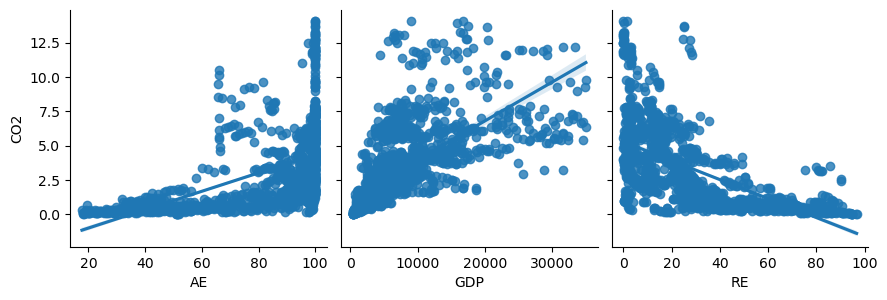

In [111]:
# Verificando outliers
dsa_get_pairs(dsa_dados, alvo, atributos, 3)

In [112]:
# Correlação das variáveis numéricas no conjunto de dados
dsa_dados.corr()

,AE,GDP,RE,CO2
AE,1.000000,0.504750,-0.738998,0.560693
GDP,0.504750,1.000000,-0.467407,0.681812
RE,-0.738998,-0.467407,1.000000,-0.639738
CO2,0.560693,0.681812,-0.639738,1.000000


In [113]:
# Separando variáveis independentes (X) e dependente (y)
X = dsa_dados[['AE', 'GDP', 'RE']]
y = dsa_dados['CO2']

In [114]:
# Dividindo os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [115]:
# Inicializando e treinando o RandomForestRegressor
modelo = RandomForestRegressor(n_estimators = 100, random_state = 42)
modelo.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [116]:
# Fazendo previsões com o conjunto de teste
y_pred = modelo.predict(X_test)

In [117]:
# Avaliando o modelo
mse = metrics.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

In [118]:
print(f"RMSE: {rmse}")

RMSE: 1.2596348385962384


In [119]:
print('R2 Score:', metrics.r2_score(y_test, y_pred))

R2 Score: 0.8405434956296118


In [120]:
# Identificando a importância das variáveis
importancias = modelo.feature_importances_
variaveis = X.columns

In [121]:
# Dataframe das variáveis mais relevantes
importancias_df = pd.DataFrame({'Variável': variaveis, 
                                'Importância': importancias}).sort_values(by = 'Importância', 
                                                                          ascending = False)

In [122]:
print(importancias_df)

  Variável  Importância
1      GDP     0.590653
2       RE     0.262296
0       AE     0.147051


In [123]:
# Split dos dados em X e Y
X = dsa_dados[['AE', 'GDP', 'RE']].values
y = dsa_dados.CO2.values.reshape(-1,1)

In [124]:
# Split em treino e teste
x_treino, x_teste, y_treino, y_teste = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [125]:
len(x_treino)

1241

In [126]:
len(y_treino)

1241

In [127]:
len(x_teste)

311

In [128]:
len(y_teste)

311

In [129]:
# Criamos o padronizador
dsa_scaler = StandardScaler()

In [130]:
# Fazemos o Fit somente com dados de treino!!!
dsa_scaler.fit(x_treino)

StandardScaler()

In [131]:
# Aplicamos o scaler nos dados de treino e teste
x_treino_scaled = dsa_scaler.transform(x_treino)
x_teste_scaled = dsa_scaler.transform(x_teste)

In [132]:
x_treino_scaled

array([[-0.40359965, -0.46910375, -1.01672011],
       [ 0.57148248, -0.0388498 , -0.98026512],
       [-0.02302151, -0.38109348, -1.05503504],
       ...,
       [ 0.75953692,  1.37560057, -0.68006944],
       [-1.95896992, -0.83159563,  0.76622644],
       [ 0.67628604,  1.12287948, -1.11194946]])

In [133]:
x_treino_scaled.shape

(1241, 3)

In [134]:
x_teste_scaled.shape

(311, 3)

In [135]:
# Cria o modelo
modelo_dsa_v1 = LinearRegression()

In [136]:
# Treinamento do modelo
modelo_dsa_v1.fit(x_treino_scaled, y_treino)

LinearRegression()

In [137]:
# O que o modelo aprendeu:
print("Coeficientes: \n", modelo_dsa_v1.coef_)

Coeficientes: 
 [[ 0.0810071   1.36720059 -1.14979067]]


In [138]:
# Previsões com dados de treino
y_pred_treino_v1 = modelo_dsa_v1.predict(x_treino_scaled)

In [139]:
# Print das métricas em treino
print('Mean Absolute Error:', metrics.mean_absolute_error(y_treino, y_pred_treino_v1))
print('Mean Squared Error:', metrics.mean_squared_error(y_treino, y_pred_treino_v1))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_treino, y_pred_treino_v1)))
print('R2 Score:', metrics.r2_score(y_treino, y_pred_treino_v1))

Mean Absolute Error: 1.3053673957566516
Mean Squared Error: 3.5296401184198465
Root Mean Squared Error: 1.8787336475455605
R2 Score: 0.582441075839114


In [140]:
# Previsões com dados de teste com padronização (CORRETO!!!!!!!!)
y_pred_teste_v1 = modelo_dsa_v1.predict(x_teste_scaled)

In [141]:
# Dataframe com as previsões e valores reais
df_previsoes = pd.DataFrame({'Valor_Real': y_teste.flatten(), 'Valor_Previsto': y_pred_teste_v1.flatten()})

In [142]:
# Visualiza
df_previsoes.head()

,Valor_Real,Valor_Previsto
0,0.645058,1.008098
1,1.777224,2.770004
2,0.767887,1.269653
3,7.251237,6.876403
4,1.751452,2.624483


In [143]:
# Função para criar gráfico de dispersão
def dsa_cria_scatter(x, y, title, xlabel, ylabel):
    
    # Figura e subplots
    fig, ax = plt.subplots(figsize = (10, 6))
    
    # Scatter
    ax.scatter(x, y, color = "blue", alpha = 0.3)

    # Labels
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    return

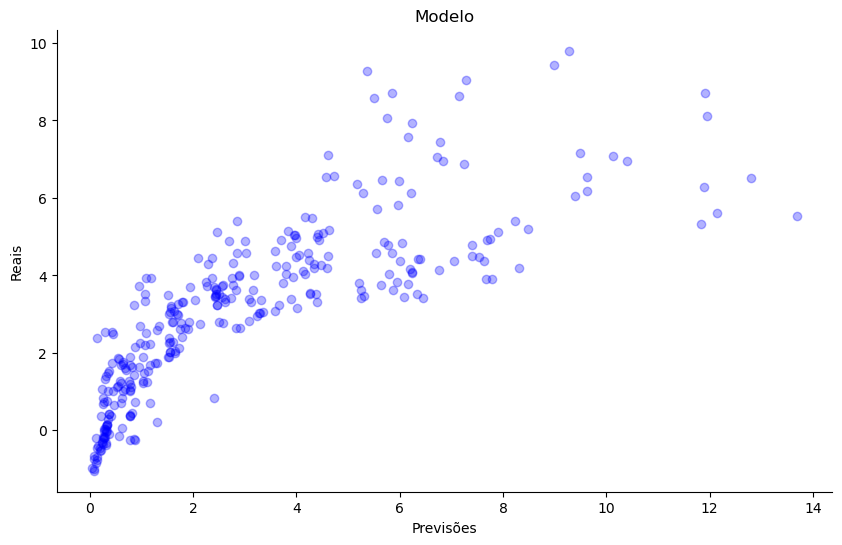

In [144]:
# Plot das previsões
dsa_cria_scatter(df_previsoes.Valor_Real, df_previsoes.Valor_Previsto, 'Modelo', 'Previsões', 'Reais')

In [145]:
# Print das métricas com dados de teste
print('Mean Absolute Error:', metrics.mean_absolute_error(y_teste, y_pred_teste_v1))
print('Mean Squared Error:', metrics.mean_squared_error(y_teste, y_pred_teste_v1))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_teste, y_pred_teste_v1)))
print('R2 Score:', metrics.r2_score(y_teste, y_pred_teste_v1))

Mean Absolute Error: 1.2102534655183874
Mean Squared Error: 2.736844641541175
Root Mean Squared Error: 1.6543411502894967
R2 Score: 0.6578206073833919


In [146]:
# O alpha controla a força da regularização
modelo_dsa_v2 = Lasso(alpha = 1.0)  

In [147]:
# Treina o modelo
modelo_dsa_v2.fit(x_treino_scaled, y_treino)

Lasso()

In [148]:
# Previsões com dados de treino
y_pred_treino_v2 = modelo_dsa_v2.predict(x_treino_scaled)

In [149]:
# Print das métricas em treino
print('Mean Absolute Error:', metrics.mean_absolute_error(y_treino, y_pred_treino_v2))
print('Mean Squared Error:', metrics.mean_squared_error(y_treino, y_pred_treino_v2))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_treino, y_pred_treino_v2)))
print('R2 Score:', metrics.r2_score(y_treino, y_pred_treino_v2))

Mean Absolute Error: 1.6167760069686032
Mean Squared Error: 4.893675518047034
Root Mean Squared Error: 2.212165346000844
R2 Score: 0.4210747226482181


In [150]:
# Previsões com dados de teste com padronização 
y_pred_teste_v2 = modelo_dsa_v2.predict(x_teste_scaled)

In [151]:
# Print das métricas com dados de teste
print('Mean Absolute Error:', metrics.mean_absolute_error(y_teste, y_pred_teste_v2))
print('Mean Squared Error:', metrics.mean_squared_error(y_teste, y_pred_teste_v2))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_teste, y_pred_teste_v2)))
print('R2 Score:', metrics.r2_score(y_teste, y_pred_teste_v2))

Mean Absolute Error: 1.5650240510974915
Mean Squared Error: 4.237358142992358
Root Mean Squared Error: 2.0584844286494755
R2 Score: 0.47021595100419233


In [152]:
# Cria o modelo com regularização Ridge
# O alpha é o parâmetro de regularização
modelo_dsa_v3 = Ridge(alpha = 1.0)  

In [153]:
# Treinamento do modelo
modelo_dsa_v3.fit(x_treino_scaled, y_treino)

Ridge()

In [154]:
# Previsões com dados de treino
y_pred_treino_v3 = modelo_dsa_v3.predict(x_treino_scaled)

In [155]:
# Print das métricas em treino
print('Mean Absolute Error:', metrics.mean_absolute_error(y_treino, y_pred_treino_v3))
print('Mean Squared Error:', metrics.mean_squared_error(y_treino, y_pred_treino_v3))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_treino, y_pred_treino_v3)))
print('R2 Score:', metrics.r2_score(y_treino, y_pred_treino_v3))

Mean Absolute Error: 1.3053160944831521
Mean Squared Error: 3.529642908487992
Root Mean Squared Error: 1.8787343900849827
R2 Score: 0.5824407457720777


In [156]:
# Previsões com dados de teste com padronização 
y_pred_teste_v3 = modelo_dsa_v3.predict(x_teste_scaled)

In [157]:
# Print das métricas com dados de teste
print('Mean Absolute Error:', metrics.mean_absolute_error(y_teste, y_pred_teste_v3))
print('Mean Squared Error:', metrics.mean_squared_error(y_teste, y_pred_teste_v3))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_teste, y_pred_teste_v3)))
print('R2 Score:', metrics.r2_score(y_teste, y_pred_teste_v3))

Mean Absolute Error: 1.2102732981696027
Mean Squared Error: 2.7370974655453715
Root Mean Squared Error: 1.6544175608187226
R2 Score: 0.6577889975642295


In [158]:
# Cria o modelo com regularização Elastic Net
# alpha é a força da regularização; l1_ratio é a mistura entre L1 e L2
modelo_dsa_v4 = ElasticNet(alpha = 1.0, l1_ratio = 0.5)  

In [159]:
# Treinamento do modelo
modelo_dsa_v4.fit(x_treino_scaled, y_treino)

ElasticNet()

In [160]:
# Previsões com dados de treino
y_pred_treino_v4 = modelo_dsa_v4.predict(x_treino_scaled)

In [161]:
# Print das métricas em treino
print('Mean Absolute Error:', metrics.mean_absolute_error(y_treino, y_pred_treino_v4))
print('Mean Squared Error:', metrics.mean_squared_error(y_treino, y_pred_treino_v4))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_treino, y_pred_treino_v4)))
print('R2 Score:', metrics.r2_score(y_treino, y_pred_treino_v4))

Mean Absolute Error: 1.4984232427008006
Mean Squared Error: 4.456304493286372
Root Mean Squared Error: 2.1109960903058
R2 Score: 0.472816024432822


In [162]:
# Previsões com dados de teste com padronização 
y_pred_teste_v4 = modelo_dsa_v4.predict(x_teste_scaled)

In [163]:
# Print das métricas com dados de teste
print('Mean Absolute Error:', metrics.mean_absolute_error(y_teste, y_pred_teste_v4))
print('Mean Squared Error:', metrics.mean_squared_error(y_teste, y_pred_teste_v4))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_teste, y_pred_teste_v4)))
print('R2 Score:', metrics.r2_score(y_teste, y_pred_teste_v4))

Mean Absolute Error: 1.4431402619452225
Mean Squared Error: 3.7967185348262893
Root Mean Squared Error: 1.9485170091190607
R2 Score: 0.525307786030743


In [164]:
# Definição do modelo
modelo_dsa_v5 = Ridge()

In [165]:
# Definição do espaço de hiperparâmetros para otimização
parametros = {'alpha': [0.01, 0.1, 1, 10, 100]}

In [166]:
# Configuração do GridSearchCV
grid_search_dsa = GridSearchCV(estimator = modelo_dsa_v5, 
                               param_grid = parametros, 
                               cv = 5, 
                               scoring = 'neg_mean_squared_error', 
                               verbose = 1)

In [167]:
# Treinamento com otimização de hiperparâmetros
grid_search_dsa.fit(x_treino_scaled, y_treino)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.01, 0.1, 1, 10, 100]},
             scoring='neg_mean_squared_error', verbose=1)

In [168]:
# Melhor modelo
melhor_modelo = grid_search_dsa.best_estimator_

In [169]:
# Previsões com dados de treino
y_pred_treino_v5 = melhor_modelo.predict(x_treino_scaled)

In [170]:
# Métricas em treino
print('Mean Absolute Error:', metrics.mean_absolute_error(y_treino, y_pred_treino_v5))
print('Mean Squared Error:', metrics.mean_squared_error(y_treino, y_pred_treino_v5))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_treino, y_pred_treino_v5)))
print('R2 Score:', metrics.r2_score(y_treino, y_pred_treino_v5))

Mean Absolute Error: 1.3053668839687746
Mean Squared Error: 3.529640118700069
Root Mean Squared Error: 1.878733647620138
R2 Score: 0.5824410758059635


In [171]:
# Previsões com dados de teste
y_pred_teste_v5 = melhor_modelo.predict(x_teste_scaled)

In [172]:
# Métricas com dados de teste
print('Mean Absolute Error:', metrics.mean_absolute_error(y_teste, y_pred_teste_v5))
print('Mean Squared Error:', metrics.mean_squared_error(y_teste, y_pred_teste_v5))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_teste, y_pred_teste_v5)))
print('R2 Score:', metrics.r2_score(y_teste, y_pred_teste_v5))

Mean Absolute Error: 1.21025366743206
Mean Squared Error: 2.736847145166775
Root Mean Squared Error: 1.6543419069729133
R2 Score: 0.6578202943626694


In [173]:
# Imprime o melhor hiperparâmetro
print('Melhor alpha:', grid_search_dsa.best_params_['alpha'])

Melhor alpha: 0.01


In [174]:
print('RMSE V1:', np.sqrt(metrics.mean_squared_error(y_teste, y_pred_teste_v1)))
print('RMSE V2:', np.sqrt(metrics.mean_squared_error(y_teste, y_pred_teste_v2)))
print('RMSE V3:', np.sqrt(metrics.mean_squared_error(y_teste, y_pred_teste_v3)))
print('RMSE V4:', np.sqrt(metrics.mean_squared_error(y_teste, y_pred_teste_v4)))
print('RMSE V5:', np.sqrt(metrics.mean_squared_error(y_teste, y_pred_teste_v5)))

RMSE V1: 1.6543411502894967
RMSE V2: 2.0584844286494755
RMSE V3: 1.6544175608187226
RMSE V4: 1.9485170091190607
RMSE V5: 1.6543419069729133


In [175]:
print('R2 Score Modelo V1:', metrics.r2_score(y_teste, y_pred_teste_v1))
print('R2 Score Modelo V2:', metrics.r2_score(y_teste, y_pred_teste_v2))
print('R2 Score Modelo V3:', metrics.r2_score(y_teste, y_pred_teste_v3))
print('R2 Score Modelo V4:', metrics.r2_score(y_teste, y_pred_teste_v4))
print('R2 Score Modelo V5:', metrics.r2_score(y_teste, y_pred_teste_v5))

R2 Score Modelo V1: 0.6578206073833919
R2 Score Modelo V2: 0.47021595100419233
R2 Score Modelo V3: 0.6577889975642295
R2 Score Modelo V4: 0.525307786030743
R2 Score Modelo V5: 0.6578202943626694


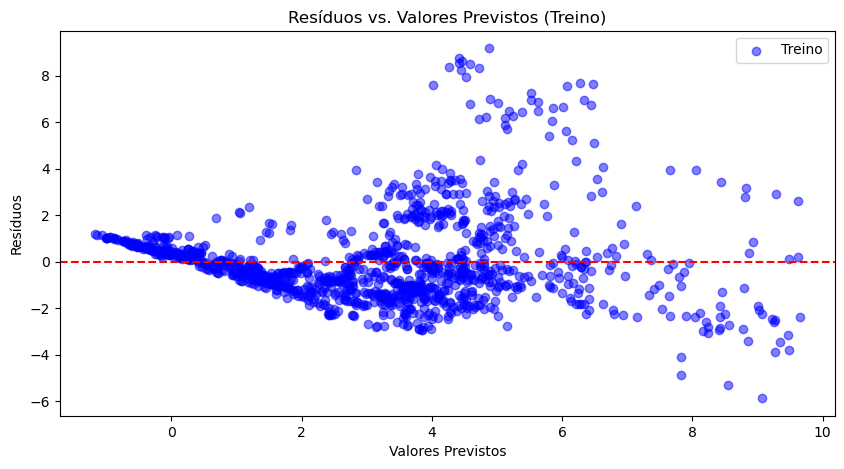

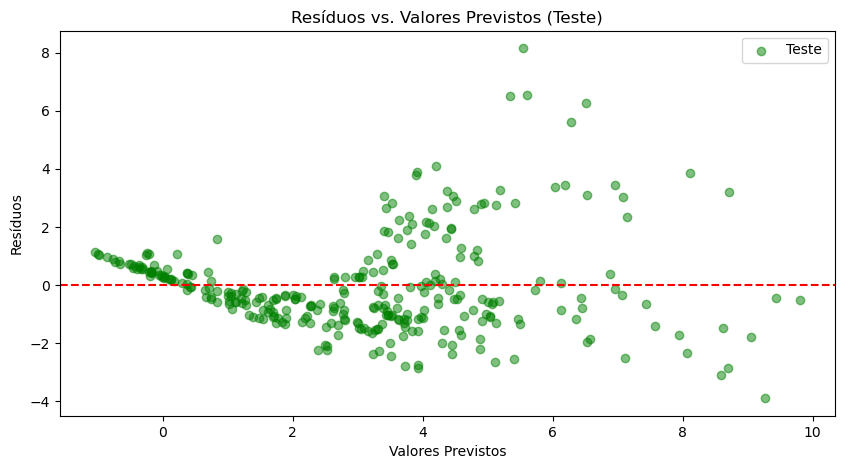

In [176]:
# Calculando os resíduos para o conjunto de treino
residuos_treino = y_treino - y_pred_treino_v1

# Calculando os resíduos para o conjunto de teste
residuos_teste = y_teste - y_pred_teste_v1

# Plotando os resíduos do conjunto de treino
plt.figure(figsize = (10, 5))
plt.scatter(y_pred_treino_v1, residuos_treino, color = 'blue', label = 'Treino', alpha = 0.5)
plt.axhline(y = 0, color = 'red', linestyle = '--')
plt.xlabel('Valores Previstos')
plt.ylabel('Resíduos')
plt.title('Resíduos vs. Valores Previstos (Treino)')
plt.legend()
plt.show()

# Plotando os resíduos do conjunto de teste
plt.figure(figsize = (10, 5))
plt.scatter(y_pred_teste_v1, residuos_teste, color = 'green', label = 'Teste', alpha = 0.5)
plt.axhline(y = 0, color = 'red', linestyle = '--')
plt.xlabel('Valores Previstos')
plt.ylabel('Resíduos')
plt.title('Resíduos vs. Valores Previstos (Teste)')
plt.legend()
plt.show()